# Workable Weather Window Analysis (WOWW Analysis)

This notebook aims to perform a workable weather window analysis of marine activities using [**waves**](https://polar.ncep.noaa.gov/waves/ensemble/download.shtml) and [**currents**](https://resources.marine.copernicus.eu/product-detail/GLOBAL_ANALYSIS_FORECAST_PHY_001_024/INFORMATION) forecasts. The analysis is based on the [DNV Offshore Standards for Marine Operations (DNV-OS-H101)](https://rules.dnv.com/docs/pdf/DNVPM/codes/docs/2011-10/Os-H101.pdf).

#### Notes
- By the time of the conception of this notebook, the datasets used were actual forecasts. Nonetheless, the principle is still aplicable for up-to-date forecast data from the mentioned sources.

## Importing libs

In [15]:
import pandas as pd
idx = pd.IndexSlice
import numpy as np
import xarray as xr
from wowwanalysis import woww_analysis

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

from glob import glob

import os
import warnings
warnings.filterwarnings('ignore')

## Loading data

A pre-processing step based on previous knowledge of the chosen forecasts dataset (WAVEWATCH III and MERCATOR) is also performed.

In [16]:
# General folder
data_folder_path = 'C:/Users/camin/portfolio/data/'

# WAVES
# loading
os.chdir(os.path.join(data_folder_path + 'waves/forecast')) # chdir
list_of_files = glob('*.nc') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
waves = xr.open_dataset(latest_file) # load
# pre-processing
waves = waves.rename({'longitude':'lon','latitude':'lat'})
waves['lon'] = waves['lon'] - 360
waves = waves.squeeze(drop=True)

# CURRENTS
# loading
os.chdir(os.path.join(data_folder_path +  'currents/forecast/hourly_surface')) # chdir
list_of_files = glob('*.nc') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
curr = xr.open_dataset(latest_file)
# pre-processing
curr = curr.rename({'longitude':'lon','latitude':'lat'}) # standardizing names
curr = curr.squeeze(drop=True) # squeezing dimentions to surface waters
# curr['uo'].values = curr['uo'].values*1.94384
# curr['uo'] = curr['uo'].assign_attrs(units='kt')
# curr['vo'].values = curr['vo'].values*1.94384
# curr['vo'] = curr['vo'].assign_attrs(units='kt')
curr['cvel'] = np.sqrt(curr['uo']**2 + curr['vo']**2)
curr['cvel'] = curr['cvel'].assign_attrs(units='kt')


## Data Selection

Let's say we want to perform the analysis at lon/lat -36.0/0., which is located in the equatorial Atlantic Ocean.

In [17]:
# Selection
lon_par = -36.
lat_par = 0.
waves = waves.sel(lon=lon_par,lat=lat_par,method='nearest')
curr = curr.sel(lon=lon_par,lat=lat_par,method='nearest')

In [4]:
waves

<xarray.Dataset>
Dimensions:  (time: 139)
Coordinates:
  * time     (time) datetime64[ns] 2022-02-18 ... 2022-02-23T18:00:00
    lat      float32 0.0
    lon      float32 -36.0
Data variables:
    Tdir     (time) float32 ...
    Tper     (time) float32 ...
    Thgt     (time) float32 ...
    sdir     (time) float32 ...
    sper     (time) timedelta64[ns] ...
    shgt     (time) float32 ...
    wdir     (time) float32 ...
    wper     (time) timedelta64[ns] ...
    whgt     (time) float32 ...
Attributes: (12/68)
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    acknowledgement:               The Pacific Islands Ocean Observing System...
    cdm_data_type:                 Grid
    comment:                       Model runs produced by Kwok Fai Cheung (ch...
    Conventions:                   CF-1.6, ACDD-1.3
    creator_email:                 cheung@hawaii.edu
    ...                            ...
    testOutOfDate:                 now+105hours
    time_coverage_end:             2022-02-23T18:00:00Z
    time_coverage_resolution:      PT1H
    time_coverage_start:           2022-02-18T00:00:00Z
    title:                         WaveWatch III (WW3) Global Wave Model
    Westernmost_Easting:           310.0

## Data Merge

For the best functioning of the analysis function, the aimed parameters must be merged along the time dimension. 

In [5]:
# Check time range of datasets
def get_date_range(data):
    start = data['time'].min().values.astype('str')[:19]
    end = data['time'].max().values.astype('str')[:19]
    rang = f'{start} - {end}'
    return rang
def get_time_step(data):
    start = data['time'][0].values
    end = data['time'][1].values
    time_step = pd.to_timedelta(end - start)
    return time_step

print(f'waves Time range: {get_date_range(waves)}, time step = ({get_time_step(waves)})')
print(f'curr Time range: {get_date_range(curr)}, time step = ({get_time_step(curr)})')

waves Time range: 2022-02-18T00:00:00 - 2022-02-23T18:00:00, time step = (0 days 01:00:00)
curr Time range: 2022-02-18T00:30:00 - 2022-02-28T23:30:00, time step = (0 days 01:00:00)


As we can notice, the datasets have different time references. To allow a propper merge along the time, a quick processing is needed.

#### Currents time processing

In [6]:
# Currents data interpolation
curr_res = curr.resample(time='30T').interpolate()
time_sel = curr_res['time'][1::2]
curr_res = curr_res.sel(time=time_sel)

In [7]:
# TIME RANGE TEST
print(f'waves Time range: {get_time_step(waves)}')
print(f'curr Time range: {get_time_step(curr_res)}')

waves Time range: 0 days 01:00:00
curr Time range: 0 days 01:00:00


#### Merging datasets

In [9]:
# waves + currents data
data_wc = waves.merge(curr_res)
data_wc = data_wc[['Thgt','Tper','cvel']].dropna(dim='time')

In [10]:
data_wc

<xarray.Dataset>
Dimensions:  (time: 138)
Coordinates:
  * time     (time) datetime64[ns] 2022-02-18T01:00:00 ... 2022-02-23T18:00:00
    lat      float32 0.0
    lon      float32 -36.0
Data variables:
    Thgt     (time) float32 1.55 1.55 1.54 1.54 1.53 ... 1.9 1.9 1.89 1.88 1.88
    Tper     (time) float32 8.621 8.547 8.547 8.547 ... 11.49 11.49 11.49 11.49
    cvel     (time) float64 0.1696 0.1623 0.1539 0.1442 ... 0.4117 0.4331 0.4504
Attributes: (12/68)
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    acknowledgement:               The Pacific Islands Ocean Observing System...
    cdm_data_type:                 Grid
    comment:                       Model runs produced by Kwok Fai Cheung (ch...
    Conventions:                   CF-1.6, ACDD-1.3
    creator_email:                 cheung@hawaii.edu
    ...                            ...
    testOutOfDate:                 now+105hours
    time_coverage_end:             2022-02-23T18:00:00Z
    time_coverage_resolution:      PT1H
    time_coverage_start:           2022-02-18T00:00:00Z
    title:                         WaveWatch III (WW3) Global Wave Model
    Westernmost_Easting:           310.0

# Performing the WOWW Analysis

## Situation 1

With the available forecast dataset, let's assume the hypothetical marine operation:

**Operation:** Crane lifting (ship to offshore platform)
- Estimated Operation Start (op_start): 2022-02-23T00:00:00 
- Last Weather Forecast Issuance (wf_issuance): 2022-02-22T18:00:00

<br>

With prior knowledge on the specific operation, the following criteria can be designed by the operation specialist: 

**Operational limits**
- Significant Wave Height Limit (thgt_limit) = 2 m
- Peak Wave Period Limit (tper_limit) = 10 s
- Surface Currents Velocity Limit (cvel_limit) = 0.6 kt

**Time Reference Calculations**
- Contigency Time Factor = 0.5

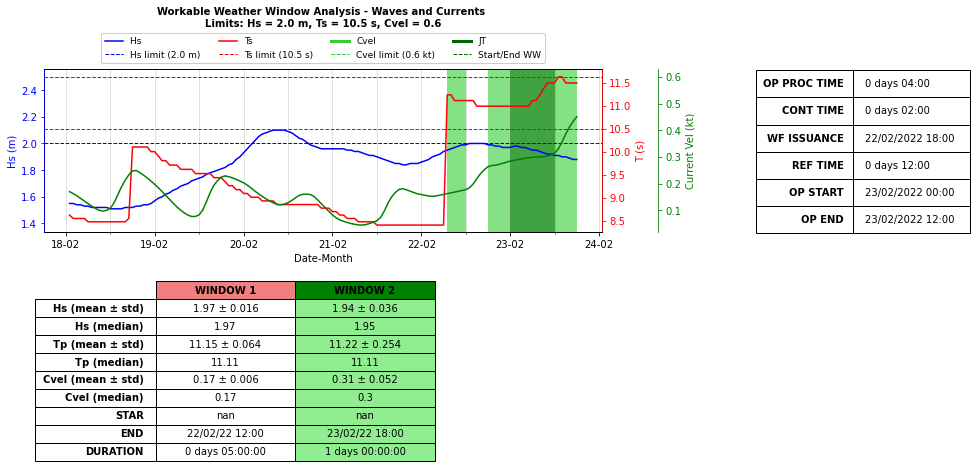

In [11]:
op_start=pd.to_datetime('2022-02-23T00:00:00')
wf_issuance=pd.to_datetime('2022-02-22T18:00:00')


woww_analysis(data_wc,
              op_start=op_start,
              tpop=4,
              cont_factor=0.5,
              toggle_op=True,
              toggle_op_plot=True,
              wf_issuance=wf_issuance,
              thgt_limit=2.,
              tper_limit=10.5,
              cvel_limit=0.6,
              figsize=(10,3))

### Discussion
With the analysis results, the specialist is now capable of taking relevant decisions regarding the viability of the operation with the available windows. In fact, by the time of the previously intended start of the operation, the **window 2** falls into the operation restraints and encompasses the whole operation time reference, therefore **safely allowing the operation to occur**. Note that the analysis returned other window (window 1) in the descriptive statistical table, but marked it with red color, once its period duration is smaller than the calculated Reference Time (procedure duration + contigency time + time from last weather forecast issuance) for the operation.
<br>
<br>
Now, let us assume that the significant wave height is the most important parameter for the said operation, and that the peak wave period is not that important. The specialist notes that, considering that the changes in peak wave period throughout the forecast data is very small, the earlier periods shows better (lower) values of significant wave height. With all the precautions taken, he then manages to lower the pre-defined peak wave period limit to 9 s, resulting in the following results:


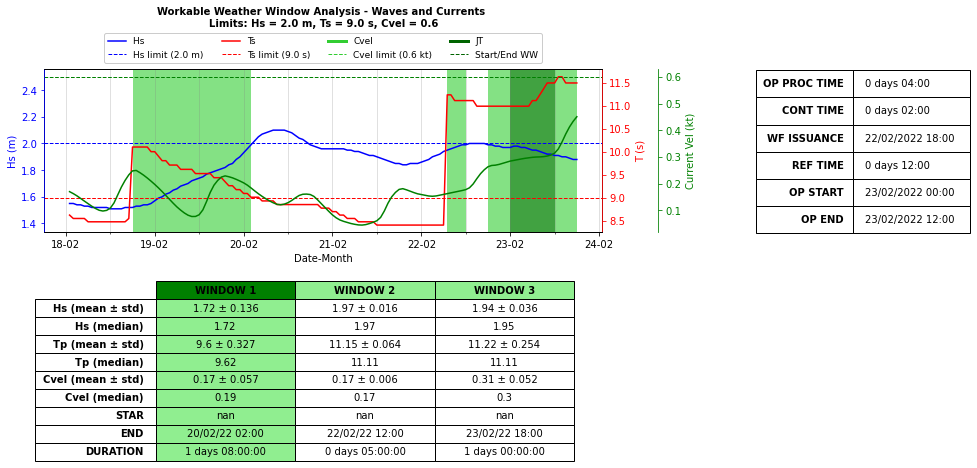

In [12]:
op_start=pd.to_datetime('2022-02-23T00:00:00')
wf_issuance=pd.to_datetime('2022-02-22T18:00:00')


woww_analysis(data_wc,
              op_start=op_start,
              tpop=4,
              cont_factor=0.5,
              toggle_op=True,
              toggle_op_plot=True,
              wf_issuance=wf_issuance,
              thgt_limit=2.,
              tper_limit=9.,
              cvel_limit=0.6,
              figsize=(10,3))

As you can see, now three possible windows (within the operational limits) were returned. As all of their periods duration are greater than the calculated Reference Time of the operation, all of them are marked as green. However, note that, by comparing the windows statistical parameters, the best (safest, i.e. furthest from the operational limit) one is the window 1, which is highlighted by the coloring of the whole column.
<br>
<br>
Lastly, the specialist then makes some arrangements with his colleagues and changes the estimated start of the operation to the a period within the window 1. The following results are computed:

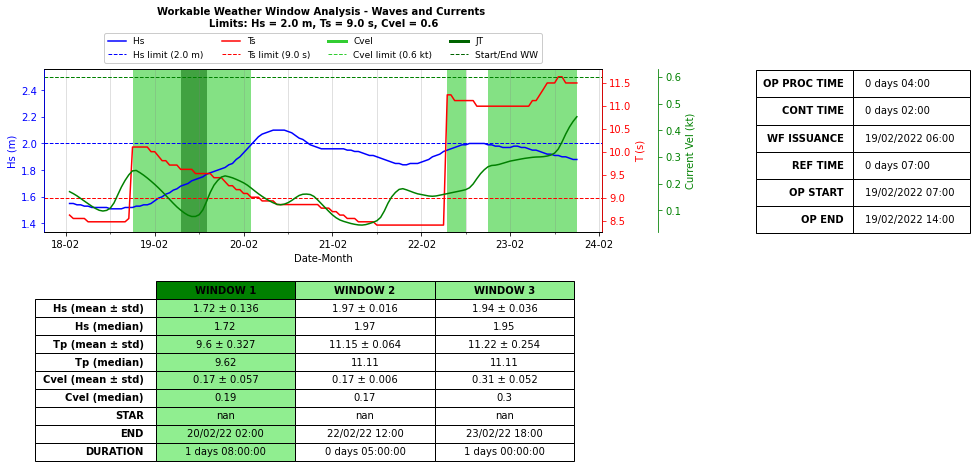

In [13]:
op_start=pd.to_datetime('2022-02-19T07:00:00')
wf_issuance=pd.to_datetime('2022-02-19T06:00:00')


woww_analysis(data_wc,
              op_start=op_start,
              tpop=4,
              cont_factor=0.5,
              toggle_op=True,
              toggle_op_plot=True,
              wf_issuance=wf_issuance,
              thgt_limit=2.,
              tper_limit=9.,
              cvel_limit=0.6,
              figsize=(10,3))

Now, with the new estimated start time of the operation, a much closer weather forecast issuance can be retrived before the operation begins. This results in a lower Reference Time duration, which can be translated in lower operational costas and higher safety.

## Situation 2

Now, for the very same period, another operation must be conducted in the same spot.

**Operation:** Structure underwater welding (offshore platform)
- Estimated Operation Start (op_start): 2022-02-23T00:00:00 
- Last Weather Forecast Issuance (wf_issuance): 2022-02-22T18:00:00

<br>

With prior knowledge on the specific operation, the following criteria can be designed by the operation specialist: 

**Operational limits**
- Significant Wave Height Limit (thgt_limit) = 1.4 m
- Peak Wave Period Limit (tper_limit) = 13 s
- Surface Currents Velocity Limit (cvel_limit) = 0.3 kt

**Time Reference Calculations**
- Contigency Time Factor = 0.7

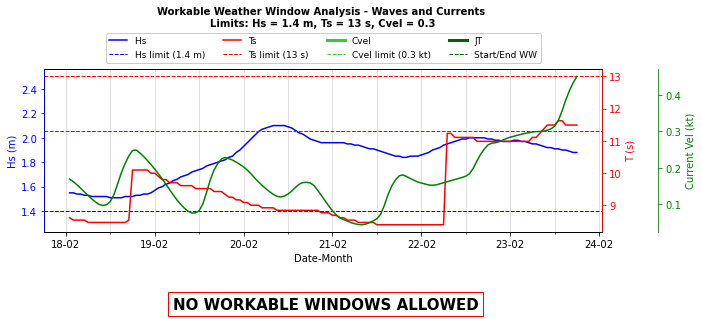

In [14]:
op_start=pd.to_datetime('2022-02-23T00:00:00')
wf_issuance=pd.to_datetime('2022-02-22T18:00:00')


woww_analysis(data_wc,
              op_start=op_start,
              tpop=4,
              cont_factor=0.5,
              toggle_op=True,
              toggle_op_plot=True,
              wf_issuance=wf_issuance,
              thgt_limit=1.4,
              tper_limit=13,
              cvel_limit=0.3,
              figsize=(10,3))

### Discussion
For the same forecast period, the analysis returned no workable weather window, as the parameters were not within the operational limits.